# 0.Setting and Dataset Download

In [ ]:
!pip3 install sklearn

!mkdir -p data  # Make data directory if it doesn't exist

## Download labeled twitter chat dataset and unzip
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/sentiment140-subset.csv.zip -P data
!unzip -n -d data data/sentiment140-subset.csv.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=1101983d5598bf1570198434e3691b86c8e9bb0ca0a00c814b1bdb5d20b6977a
  Stored in directory: /root/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d40970a40c22c472ae50f0a1
Successfully built sklearn
--2023-05-09 05:36:24--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/sentiment140-subset.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17927149 (17M) [application/zip]
Saving to: ‘data/sentiment140-subset.csv.zip’

sentiment140-subset 100%[===================>]  17.10M  7.99MB/s    in 2.1s    

2023-05-09 05:36:27

In [ ]:
import pandas as pd  #Import library for making data frame like excel

df = pd.read_csv("data/sentiment140-subset.csv", nrows=30000)  # Read twitter dataset downloaded above
df.head()  # Display some examples. 

## Polarity means the sentiment of the texts. It is "1" if given text seems positive, and gonna be "0" for negative texts

,polarity,text
0,0,@kconsidder You never tweet
1,0,Sick today coding from the couch.
2,1,"@ChargerJenn Thx for answering so quick,I was ..."
3,1,Wii fit says I've lost 10 pounds since last ti...
4,0,@MrKinetik Not a thing!!! I don't really have...


In [ ]:
df.polarity.value_counts()  # Calculate how many texts exist for each label

1    15064
0    14936
Name: polarity, dtype: int64

# 1. Dataset preprocessing for training

## 1.1 Text Embedding 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  
## This library make texts into vectorized matrix. 
## This process enable users to handle text data mathmatically
## There are more advanced way to extract features and embedding text data, but we will use this one. 

vectorizer = TfidfVectorizer(max_features=1000)  # Make vectorizer that embeds texts to 1000 dimensional matrix

vectors = vectorizer.fit_transform(df.text)
words_df = pd.DataFrame(vectors.toarray(), columns = vectorizer.get_feature_names_out())

words_df.head()

,10,100,11,12,15,1st,20,2day,2nd,30,...,yesterday,yet,yo,you,young,your,yourself,youtube,yum,yup
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.334095,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.427465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 1.2 Test / Train Split

In [ ]:
from sklearn.model_selection import train_test_split
## In machine learing, you need to make sure your model perform well for unseen data. 
## There are various strategies to train model and evaluate its performance,
## but in our case we will just split our dataset train(80%) and test(20%). 
## The train dataset will be used to train our model, and test dataset will be used to evaluate our trained model. 

df_y_sentiment = df['polarity']
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(words_df, df_y_sentiment, test_size=0.2, random_state=32, stratify=df_y_sentiment)

df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)


## You need to be careful about the imbalanced class problem when you prepare your dataset for ML. 
## In our case, it seems fine.
print(df_train.polarity.value_counts())
print(df_test.polarity.value_counts())

X_train = df_x_train
y_train = df_train.polarity

X_test = df_x_test
y_test = df_test.polarity

1    12051
0    11949
Name: polarity, dtype: int64
1    3013
0    2987
Name: polarity, dtype: int64


# 2. Classification model training and evaluation

In [ ]:
# Function for check model Performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def calculate_performance(model, X, y):
  y_pred = model.predict(X)
  cnf_matrix = confusion_matrix(y, y_pred)
  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred, pos_label=1)

  return cnf_matrix, accuracy, precision, recall, f1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
## These libraries are all for optimizing composed model.
## The optimization process is called "Machine Learning". 
## This is because the computer will learn on its own if you give it the data and the correct answer.

## 2.1 Logistic Regression

In [ ]:
%%time
## Create and train a logistic regression. You can use another one imported from above.
logreg = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)

logreg.fit(X_train, y_train)  #Put input and expected output data. Then it is optimized by itself

CPU times: user 15.2 s, sys: 787 ms, total: 15.9 s
Wall time: 8.26 s


LogisticRegression(C=1000000000.0, max_iter=1000)

In [ ]:
# Performance of train

logreg_cnf_matrix, logreg_accuracy, logreg_precision, logreg_recall, logreg_f1 = calculate_performance(logreg, X_train, y_train)

print("------Train Performance------")
print("Accuracy : {:.3f}".format(logreg_accuracy))
print("Precision : {:.3f}".format(logreg_precision))
print("Recall : {:.3f}".format(logreg_recall))
print("F1 Score : {:.3f}".format(logreg_f1))

# Performance of test

logreg_cnf_matrix, logreg_accuracy, logreg_precision, logreg_recall, logreg_f1 = calculate_performance(logreg, X_test, y_test)

print("-------Test Performance-------")
print("Accuracy : {:.3f}".format(logreg_accuracy))
print("Precision : {:.3f}".format(logreg_precision))
print("Recall : {:.3f}".format(logreg_recall))
print("F1 Score : {:.3f}".format(logreg_f1))

------Train Performance------
Accuracy : 0.779
Precision : 0.773
Recall : 0.792
F1 Score : 0.782
-------Test Performance-------
Accuracy : 0.743
Precision : 0.734
Recall : 0.767
F1 Score : 0.750


Text(0.5, 427.9555555555555, 'Predicted label')

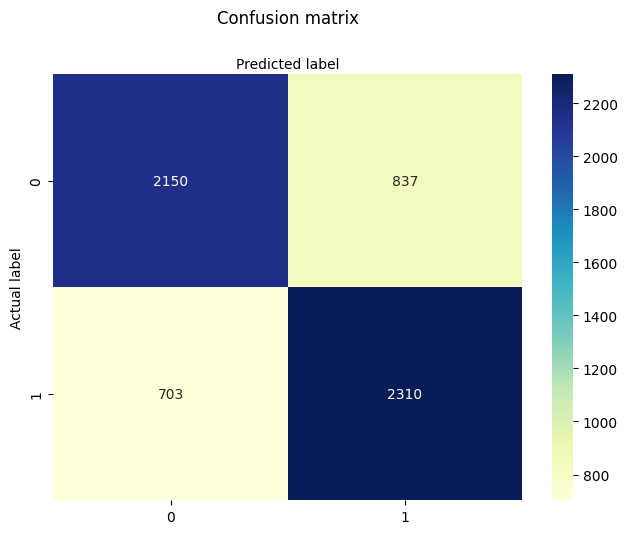

In [ ]:
# Visualize Confusion Matrix of Test dataset
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(logreg_cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 2.2 RandomForest Classifier
- Try to look up official documents and other materials to train the model.
  - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Choose proper hyperparameters to train and evaluate your model
- In my case, I get 0.69 for accuracy -- did you beat me?  



In [ ]:
##### Declare your Random Forest Classifier Here And Fit your model to train dataset #####



In [ ]:
#### Performance of train ####


#### Performance of test ####


------Train Performance------
Accuracy : 0.956
Precision : 0.954
Recall : 0.958
F1 Score : 0.956
-------Test Performance-------
Accuracy : 0.687
Precision : 0.691
Recall : 0.683
F1 Score : 0.687


## 2.3 Support Vector Machine (LinearSVC)
- Try to look up official documents and other materials to train the model.
  - https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
- Choose proper hyperparameters to train and evaluate your model
- In my case, I get 0.70 for accuracy -- did you beat me?  


In [ ]:
##### Declare your Support Vector Machine Classifier Here And Fit your model to train dataset #####



In [ ]:
#### Performance of train ####


#### Performance of test ####


## 2.4 Naive Bayes Classifer (MultinomialNB)
- Try to look up official documents and other materials to train the model.
  - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- Choose proper hyperparameters to train and evaluate your model
- In my case, I get 0.73 for accuracy -- did you beat me?  


In [ ]:
##### Declare your Naive Bayes Classifier Here And Fit your model to train dataset #####



CPU times: user 118 ms, sys: 5.87 ms, total: 124 ms
Wall time: 159 ms


MultinomialNB()

In [ ]:
#### Performance of train ####

#### Performance of test ####


------Train Performance------
Accuracy : 0.762
Precision : 0.768
Recall : 0.754
F1 Score : 0.761
-------Test Performance-------
Accuracy : 0.734
Precision : 0.738
Recall : 0.731
F1 Score : 0.734


## Model Comparison

In [ ]:
##### Visualize your model performance for comparison #####
import matplotlib.pyplot as plt # You may need to use this library

# Which ML model was best model?


# 3. Test your best model with your own comments

In [ ]:
# Which machine learning model is well trainned?
# I choosed logistic regression, but you sould choose your own best model based on performance of your each model.

pd.set_option("display.max_colwidth", 200)

## Make your own comments for test. You can make it as you want. Just keep the data frame form
MyOwnComments = pd.DataFrame({'content': [
    "I love love love love this kitten",
    "I hate hate hate hate this keyboard",
    "I'm not sure how I feel about toast",
    "Did you see the baseball game yesterday?",
    "The package was delivered late and the contents were broken",
    "Trashy television shows are some of my favorites",
    "I'm seeing a Kubrick film tomorrow, I hear not so great things about it.",
    "I find chirping birds irritating, but I know I'm not the only one",
]})
MyOwnComments

,content
0,I love love love love this kitten
1,I hate hate hate hate this keyboard
2,I'm not sure how I feel about toast
3,Did you see the baseball game yesterday?
4,The package was delivered late and the contents were broken
5,Trashy television shows are some of my favorites
6,"I'm seeing a Kubrick film tomorrow, I hear not so great things about it."
7,"I find chirping birds irritating, but I know I'm not the only one"


In [ ]:
## As mentioned, it is needed to convert texts to vectors in order to deal with text data
MyOwnComments_vectors = vectorizer.transform(MyOwnComments.content) # Put text data into vectorizer
MyOwnComments_words_df = pd.DataFrame(MyOwnComments_vectors.toarray(), columns=vectorizer.get_feature_names_out()) 
MyOwnComments_words_df.head() # Diplay vectorized data. If you can't understand what it is, it makes sense

,10,100,11,12,15,1st,20,2day,2nd,30,...,yesterday,yet,yo,you,young,your,yourself,youtube,yum,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.537291,0.0,0.0,0.244939,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# MyOwnComments['pred_logreg'] = 'YOUR BEST MODEL".predict(MyOwnComments_words_df)
MyOwnComments['pred_logreg'] = logreg.predict(MyOwnComments_words_df)  # Make one more column on "MyOwnComments" dataframe, and put predicted outputs into it

In [ ]:
# 'YOUR BEST MODEL".predict(MyOwnComments_words_df)
logreg.predict(MyOwnComments_words_df)  # Show us how it is expected by computer

array([1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
# Does your model successfully classify your comments as you intend?
MyOwnComments  # Diplay as a dataframe

,content,pred_logreg
0,I love love love love this kitten,1
1,I hate hate hate hate this keyboard,0
2,I'm not sure how I feel about toast,0
3,Did you see the baseball game yesterday?,1
4,The package was delivered late and the contents were broken,0
5,Trashy television shows are some of my favorites,0
6,"I'm seeing a Kubrick film tomorrow, I hear not so great things about it.",1
7,"I find chirping birds irritating, but I know I'm not the only one",0
